In [113]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [114]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
import numpy as np
from lightning.pytorch.loggers import WandbLogger
from pathlib import Path
from Models.VAE import VAE

In [115]:

wandb_logger = WandbLogger(log_model="all")
vae_checkpoint_reference = "team-good-models/model-registry/WorldModelVAE:latest"
vae_dir = wandb_logger.download_artifact(vae_checkpoint_reference, artifact_type="model")
vae = VAE.load_from_checkpoint(Path(vae_dir) / "model.ckpt")


wandb:   1 of 1 files downloaded.  


In [116]:
def generate_trajectory(env_name, num_steps, repeat_action=1):
    # Initialize the environment
    env = gym.make(env_name)
    # Reset the environment to get the initial observation
    observation, _ = env.reset()
    
    # Initialize arrays to store the trajectory
    observations = np.zeros((num_steps,) + env.observation_space.shape, dtype=np.float32)
    actions = np.zeros((num_steps,) + env.action_space.shape, dtype=np.float32)
    rewards = np.zeros(num_steps, dtype=np.float32)
    dones = np.zeros(num_steps, dtype=bool)
    for t in range(num_steps):
        # Store the current observation
        observations[t, :] = observation

        if t % repeat_action == 0:
            # Choose a random action (for demonstration purposes)
            action = env.action_space.sample()
        
        # Store the chosen action
        actions[t] = action
        
        # Perform the action and observe the next state and reward
        observation, reward, done, _, _ = env.step(action)
        
        # Store the reward and done flag
        rewards[t] = reward
        dones[t] = done
        
        if done:
            # If the episode is done, break out of the loop
            break
    
    # Close the environment
    env.close()
    
    # Return the trajectory
    return observations[:t+1], actions[:t+1], rewards[:t+1], dones[:t+1]



In [117]:

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def display_trajectory_as_video(video, fig_size=(8, 6), margin=0.01, interval=50):
    # np array with shape (frames, height, width, channels)

    fig, ax = plt.subplots(figsize=fig_size)
    plt.subplots_adjust(left=margin, right=(1-margin), top=(1-margin), bottom=margin)
    im = plt.imshow(video[0,:,:,:])

    text = ax.text(0.02, 0.95, 'Frame: 0', transform=ax.transAxes, color='white')

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])
        text.set_text('Frame: 0')

    def animate(i):
        im.set_data(video[i,:,:,:])
        text.set_text('Frame: ' + str(i))
        return im, text

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=interval)
    return HTML(anim.to_html5_video())


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_data_validation(vae, data, num_samples=10):
    """
    Function to perform visual data validation on a Variational Autoencoder (VAE).

    Parameters:
    - vae: Trained Variational Autoencoder model.
    - data: Input data to validate. This could be a subset of the training data.
    - num_samples: Number of samples to generate for each data point.

    Returns:
    - None
    """

    # Generate reconstructed samples and sample from latent space
    reconstructed_data, _, _, _ = vae(data)
    latent_space_samples, _, _ = vae.encoder(data)

    data = torch.movedim(data, 1, -1)
    reconstructed_data = torch.movedim(reconstructed_data, 1, -1).detach()
    
    grid = torch.concat([data, reconstructed_data], dim=2)

    display(display_trajectory_as_video(grid, fig_size=(6, 3), margin=0.05))
    
    
    latent_space_samples = latent_space_samples.detach()


    # Perform t-SNE on latent space samples
    tsne = TSNE(n_components=2, random_state=42)
    latent_space_tsne = tsne.fit_transform(latent_space_samples)

    # Color based on data position index
    colors = np.arange(len(data))

    # Plot latent space samples
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_space_tsne[:, 0], latent_space_tsne[:, 1], c=colors, cmap='viridis', marker='o')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('Latent Space (t-SNE)')
    plt.grid(True)


    # Add legend
    legend = plt.legend(*scatter.legend_elements(), title="Data Index", loc="upper right")
    plt.gca().add_artist(legend)


    plt.show()

    

In [119]:
from torchvision.transforms import transforms
from Utils.TransformerWrapper import Interpolate, Crop

transform = transforms.Compose([
    Interpolate(0, 255, 0, 1),
    transforms.ToTensor(), 
    transforms.Grayscale(), 
    Crop(bottom=-15),
    transforms.Resize((64, 64), antialias=True),
])

data, _, _, _ = generate_trajectory('CarRacing-v2', 1000, 1)
data = [transform(obs) for obs in data]

data = torch.stack(data)

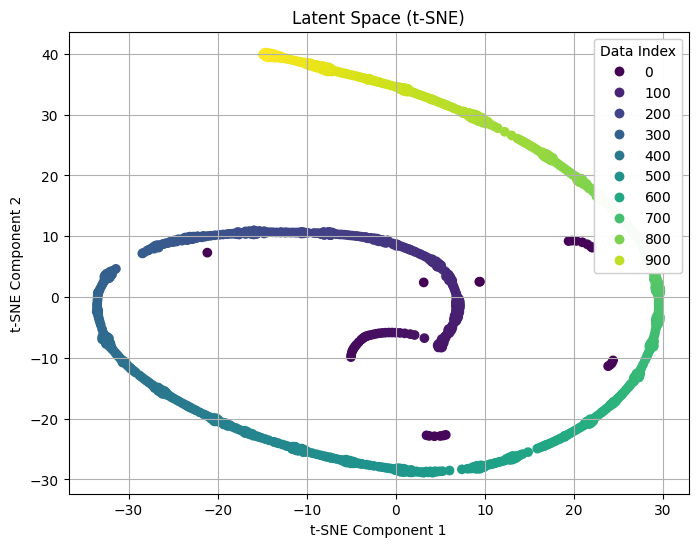

In [120]:
visualize_data_validation(vae, data)

In [121]:
from torchvision.transforms import transforms
from Utils.TransformerWrapper import Interpolate, Crop

samples = 10
all_data = []
for _ in range(samples):
    data, _, _, _ = generate_trajectory('CarRacing-v2', 1000, 1)
    data = [transform(obs) for obs in data]
    data = torch.stack(data)
    all_data.append(data)

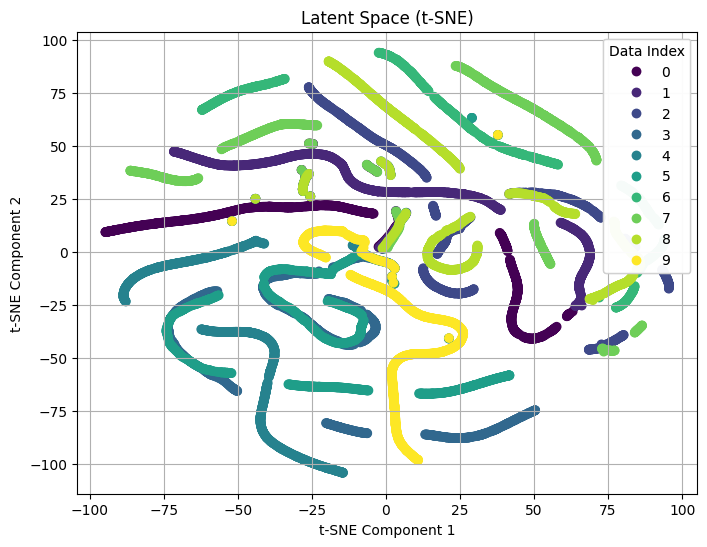

In [130]:
latent_space = []
video = []
for data in all_data:
    # Generate reconstructed samples and sample from latent space
    reconstructed_data, _, _, _ = vae(data)
    latent_space_samples, _, _ = vae.encoder(data)

    data = torch.movedim(data, 1, -1)
    reconstructed_data = torch.movedim(reconstructed_data, 1, -1).detach()
    
    grid = torch.concat([data, reconstructed_data], dim=1)
    video.append(grid)
    latent_space.append(latent_space_samples.detach())


grid = torch.concat(video, dim=2)
display(display_trajectory_as_video(grid, fig_size=(6, 3), margin=0.05))

labels = [[l,]*obs.shape[0] for l, obs in enumerate(latent_space)]
labels = sum(labels, start=[])

latent_space_samples = np.concatenate(latent_space)

# Perform t-SNE on latent space samples
tsne = TSNE(n_components=2, random_state=42)
latent_space_tsne = tsne.fit_transform(latent_space_samples)

# Plot latent space samples
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_space_tsne[:, 0], latent_space_tsne[:, 1], c=labels, cmap='viridis', marker='o')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Latent Space (t-SNE)')
plt.grid(True)


# Add legend
legend = plt.legend(*scatter.legend_elements(), title="Data Index", loc="upper right")
plt.gca().add_artist(legend)


plt.show()



In [123]:
from Models.MDNRNN import MDNRNN
from Utils.ClipRewardWrapper import ClipRewardWrapper
from Utils.TransformerWrapper import TransformWrapper
from Utils.WorldModelWrapper import WorldModelWrapper

vae_checkpoint_reference = "team-good-models/model-registry/WorldModelVAE:latest"
mdnrnn_checkpoint_reference = "team-good-models/model-registry/WorldModelMDNRNN:latest"

vae_dir = wandb_logger.download_artifact(vae_checkpoint_reference, artifact_type="model")
mdnrnn_dir = wandb_logger.download_artifact(mdnrnn_checkpoint_reference, artifact_type="model")

vae = VAE.load_from_checkpoint(Path(vae_dir) / "model.ckpt")
mdnrnn = MDNRNN.load_from_checkpoint(Path(mdnrnn_dir) / "model.ckpt", strict=False)

vae.freeze()
mdnrnn.freeze()


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [126]:


def generate_trajectory_with_dyn(env_name, num_steps, repeat_action=1):
    # Initialize the environment
    env = gym.make("CarRacing-v2", render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, './videos/CarRacing', episode_trigger=lambda x: False)  # Record videos
    env = ClipRewardWrapper(env, -0.101, 100)  
    env = TransformWrapper(env)  # Apply necessary visual transformations to the environment
    env = WorldModelWrapper(env, vae, mdnrnn, output_dim=32+256, episode_trigger=lambda x: False, use_wandb=True, device = 'cpu')
    # Reset the environment to get the initial observation
    observation, _ = env.reset()
    
    # Initialize arrays to store the trajectory
    observations = np.zeros((num_steps,) + env.observation_space.shape, dtype=np.float32)
    actions = np.zeros((num_steps,) + env.action_space.shape, dtype=np.float32)
    rewards = np.zeros(num_steps, dtype=np.float32)
    dones = np.zeros(num_steps, dtype=bool)
    linear_vel = np.zeros(num_steps, dtype=np.float32)
    ang_vel = np.zeros(num_steps, dtype=np.float32)
    for t in range(num_steps):
        # Store the current observation
        observations[t, :] = observation

        if t % repeat_action == 0:
            # Choose a random action (for demonstration purposes)
            action = env.action_space.sample()
        
        # Store the chosen action
        actions[t] = action
        
        linear_vel[t] = env.car.hull.linearVelocity.length
        ang_vel[t] = env.car.hull.angularVelocity

        # Perform the action and observe the next state and reward
        observation, reward, done, _, _ = env.step(action)
        
        # Store the reward and done flag
        rewards[t] = reward
        dones[t] = done
        


        if done:
            # If the episode is done, break out of the loop
            break
    
    # Close the environment
    env.close()
    
    # Return the trajectory
    return observations, actions, rewards, dones, linear_vel, ang_vel



In [127]:
import gymnasium as gym
from torchvision.transforms import transforms
from Utils.TransformerWrapper import Interpolate, Crop

samples = 10
X = []
y_lin = []
y_ang = []
for _ in range(samples):
    data, _, _, _, lin, ang = generate_trajectory_with_dyn('CarRacing-v2', 1000, 1)
    print(torch.tensor(data).shape)
    data = torch.tensor(data)[:,64:]
    X.append(data)
    y_lin.append(lin)
    y_ang.append(ang)

X = torch.concat(X).detach().numpy()
y_lin = np.concatenate(y_lin)
y_ang = np.concatenate(y_ang)

torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])
torch.Size([1000, 288])


<Axes: >

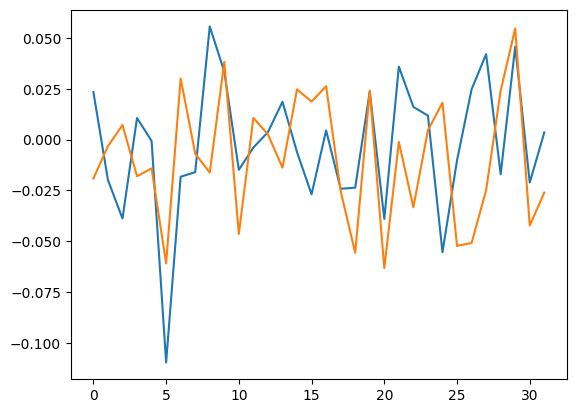

In [ ]:
import pandas as pd
pd.DataFrame(X).corrwith(pd.Series(y_lin)).plot()

pd.DataFrame(X).corrwith(pd.Series(y_ang)).plot()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

cls = RandomForestRegressor()
cls.fit(pd.DataFrame(X)[:-100], pd.Series(y_lin)[:-100])

RandomForestRegressor()

In [ ]:
cls.score(pd.DataFrame(X), y_lin)

0.9180671952631471

In [ ]:

def gaussian_mle(data):                                                                                                                                                                               
    mu = data.mean(axis=0)                                                                                                                                                                            
    var = (data-mu).T @ (data-mu) / data.shape[0] #  this is slightly suboptimal, but instructive

    return mu, var

gaussian_mle(y_lin), gaussian_mle(np.array(cls.predict(pd.DataFrame(X))))                                                                                                                                                                     

((3.1408465, 2.3755099609375), (3.124478678937241, 1.542614235863612))

In [ ]:
from torch.distributions import Normal
from sklearn.metrics import mean_squared_error

dist = Normal(*gaussian_mle(y_lin))

s = [dist.sample().numpy() for _ in range(len(y_lin))]
s_pred = cls.predict(pd.DataFrame(X)[-100:])

mean_squared_error(y_lin, s), mean_squared_error(y_lin[-100:], s_pred)

(8.11515, 2.0552223458796455)

In [129]:
X.max(), X.min()

(0.8314879, -0.7898495)

In [131]:
latent_space_samples.max(), latent_space_samples.min()

(5.278621, -4.2635117)